In [113]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [114]:
def get_rsi(data, period=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [115]:
def get_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal, macd - signal

In [116]:
def get_bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band, (upper_band - lower_band) / rolling_mean

In [117]:
def prepare_data(data):
    data['RSI'] = get_rsi(data)
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    
    macd, signal, histogram = get_macd(data)
    data['MACD'] = macd
    data['MACD_Signal'] = signal
    data['MACD_Histogram'] = histogram

    upper_band, lower_band, bandwidth = get_bollinger_bands(data)
    data['Bollinger_Upper'] = upper_band
    data['Bollinger_Lower'] = lower_band
    data['Bollinger_Bandwidth'] = bandwidth

    data['Momentum'] = data['Close'].diff(14)
    data['Volatility'] = data['Close'].pct_change().rolling(14).std()
    data['Volume_Change'] = data['Volume'].pct_change().fillna(0)

    data['Price_Change'] = data['Close'].pct_change()
    data.dropna(inplace=True)
    return data

In [118]:
def train_model(data):
    features = ['RSI', 'SMA_10', 'SMA_50', 'MACD', 'MACD_Signal', 'MACD_Histogram',
                'Bollinger_Upper', 'Bollinger_Lower', 'Bollinger_Bandwidth',
                'Momentum', 'Volatility', 'Volume_Change']

    X = data[features]
    y = data['Close']

    imputer = SimpleImputer(strategy="mean")
    X = pd.DataFrame(imputer.fit_transform(X), columns=features, index=data.index)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features, index=X_test.index)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    return model, scaler, X_test_scaled, y_test, X_test.index

In [119]:
def forecast_prices(data, model, scaler):
    future_data = data[-30:].copy()
    features = ['RSI', 'SMA_10', 'SMA_50', 'MACD', 'MACD_Signal', 'MACD_Histogram',
                'Bollinger_Upper', 'Bollinger_Lower', 'Bollinger_Bandwidth',
                'Momentum', 'Volatility', 'Volume_Change']

    future_features = future_data[features]
    future_scaled = scaler.transform(future_features)
    future_predictions = model.predict(future_scaled)

    future_dates = pd.date_range(start=data.index[-1], periods=30, freq='B')
    forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_predictions})
    
    return forecast_df

In [120]:
def plot_predictions(data, y_test, y_pred, forecast_df):
    plt.figure(figsize=(12, 6))

    plt.plot(data.index, data['Close'], label="Actual Prices", color='blue', alpha=0.6)
    plt.plot(y_test.index, y_pred, label="Predicted Prices", color='red', linestyle="dashed")

    plt.plot(forecast_df['Date'], forecast_df['Predicted_Close'], label="Forecasted Prices", color='green', linestyle="dotted")

    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.title("Stock Price Prediction & Forecast")
    plt.show()

Enter the stock ticker symbol (e.g., AAPL, MSFT, TSLA):  acp


[*********************100%***********************]  1 of 1 completed
/Users/sarthaklade/myenv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/sarthaklade/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/sarthaklade/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


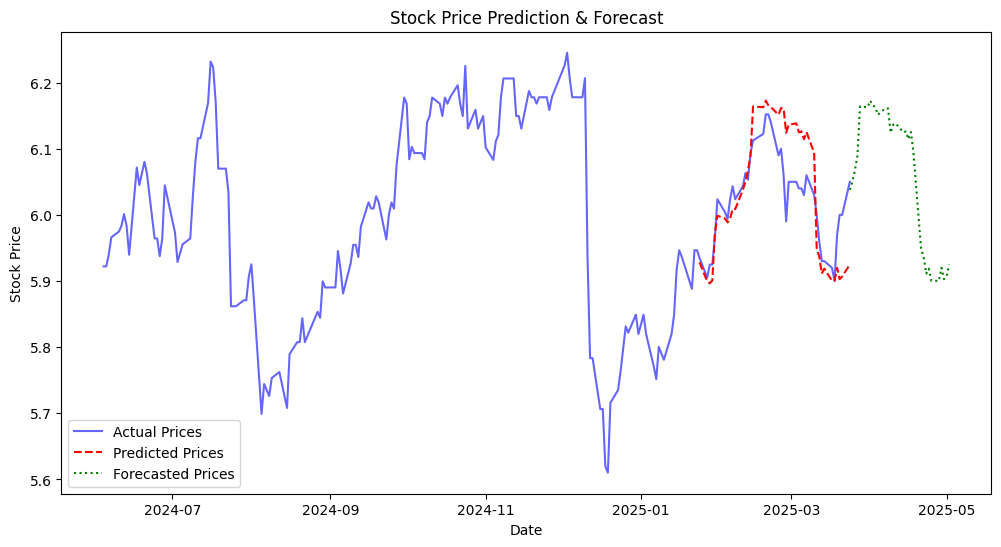

In [125]:
def analyze_stock(ticker):
    data = yf.download(ticker, period="1y")
    data = prepare_data(data)

    model, scaler, X_test_scaled, y_test, test_index = train_model(data)

    y_pred = model.predict(X_test_scaled)

    forecast_df = forecast_prices(data, model, scaler)

    plot_predictions(data, y_test, y_pred, forecast_df)

if __name__ == "__main__":
    ticker = input("Enter the stock ticker symbol: ").strip().upper()
    analyze_stock(ticker)